<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import optuna

from re import VERBOSE
from sklearn.metrics import (
    recall_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
import json
import tqdm
import shap

from hotel_preprocessing import XYPreprocessor

RANDOM_STATE = 2025
VERBOSE = 2

In [3]:
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

# Combine year, month, and day columns into a single datetime column
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel_data['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split by cutoff date
test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Separate raw features and labels
X_train_val_raw = train_val_data.drop(columns=['is_canceled'])
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(columns=['is_canceled'])
y_test_raw = test_data['is_canceled'].astype(int)
print(len(X_test_raw), len(y_test_raw))

# Preprocess train_val once, then split into folds
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)

import numpy as np
import pandas as pd

# Add unique row ID to preserve alignment
X_test_raw = X_test_raw.copy()
X_test_raw['_row_id'] = np.arange(len(X_test_raw))

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test_raw)

# If X_test_transformed is a DataFrame with index preserved:
if isinstance(X_test_transformed, pd.DataFrame):
    valid_idx = X_test_transformed.index
else:
    # If it's a NumPy array, assume same order and length corresponds to surviving rows
    # Derive index based on original index if available
    valid_idx = X_test_raw.index[:X_test_transformed.shape[0]]

# Map row IDs to align y_test
aligned_row_ids = X_test_raw.loc[valid_idx, '_row_id'].values
y_test_aligned = y_test_raw.iloc[aligned_row_ids].reset_index(drop=True)

# Reset X_test and y_test
X_test = pd.DataFrame(X_test_transformed).reset_index(drop=True)
y_test = y_test_aligned

# Sanity check
print(f"Final aligned: X_test = {len(X_test)}, y_test = {len(y_test)}")

15885 15885
Final aligned: X_test = 15845, y_test = 15845


In [4]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),  # allow deeper trees
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # prevent overfitting
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),    # prevent small noisy leaves
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # fine pruning range, log scale
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)

    return np.mean(aucs)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # increase trials for better coverage

print("Best hyperparameters:", study.best_params)


[I 2025-06-22 00:16:16,818] A new study created in memory with name: no-name-2f8faa4c-44ac-4993-9480-f2eede62bb6b
[I 2025-06-22 00:16:34,048] Trial 0 finished with value: 0.7681364565294599 and parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'ccp_alpha': 0.00010194141794345189}. Best is trial 0 with value: 0.7681364565294599.
[I 2025-06-22 00:16:48,516] Trial 1 finished with value: 0.850813334721253 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'ccp_alpha': 0.0014024729974125068}. Best is trial 1 with value: 0.850813334721253.
[I 2025-06-22 00:16:58,528] Trial 2 finished with value: 0.8275449702214038 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7, 'ccp_alpha': 0.00713211664969875}. Best is trial 1 with value: 0.850813334721253.
[I 2025-06-22 00:17:15,517] Trial 3 finished with value: 0.8946371982121063 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3, 'ccp_alpha

Best hyperparameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 3, 'ccp_alpha': 0.0001056485928970222}


In [5]:
# Final training on full training + validation data
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_train_val, y_train_val)

# Predict on test set (probabilities and binary class)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)  # threshold at 0.5

# Compute metrics
test_auc = roc_auc_score(y_test, y_test_proba)
test_recall = recall_score(y_test, y_test_pred)
# Print classification report
print(classification_report(y_test, y_test_pred))

print("Final Test AUC:", test_auc)
print("Final Test Recall:", test_recall)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      9609
           1       0.74      0.76      0.75      6236

    accuracy                           0.80     15845
   macro avg       0.79      0.80      0.79     15845
weighted avg       0.80      0.80      0.80     15845

Final Test AUC: 0.8903476391967627
Final Test Recall: 0.7625080179602309


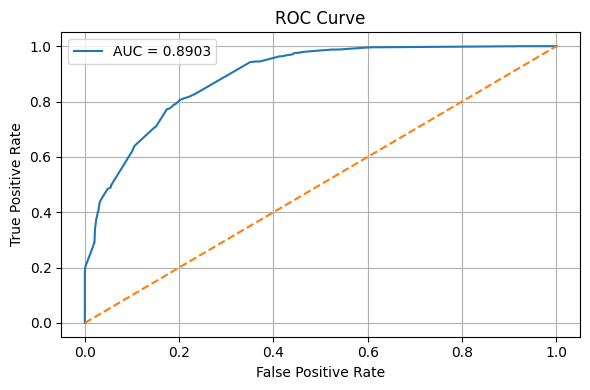

In [6]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

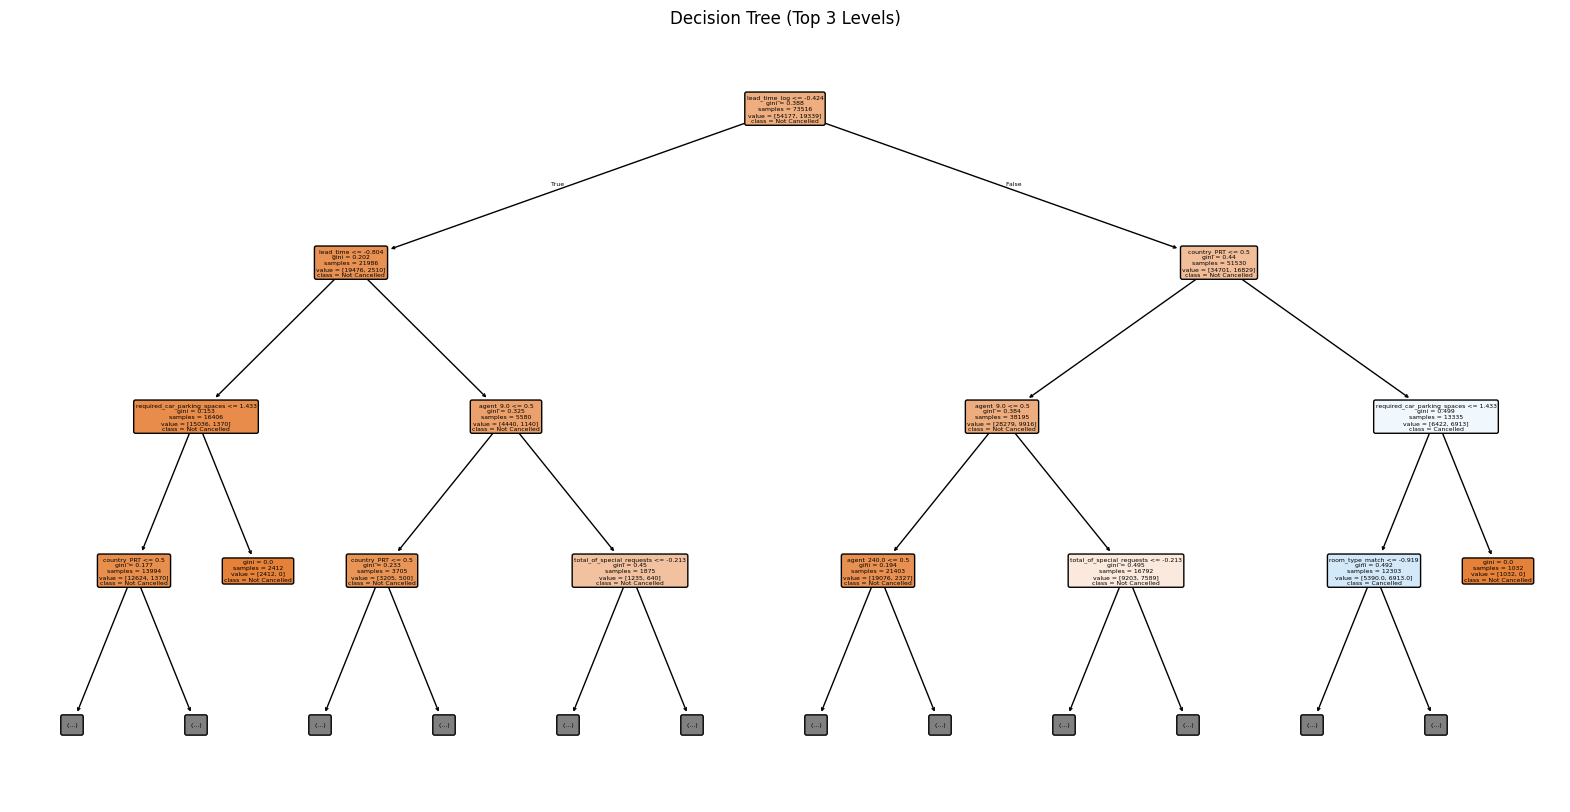

In [7]:
# Visualize the tree
levels_for_viz = 3
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train_val.columns, class_names=["Not Cancelled", "Cancelled"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

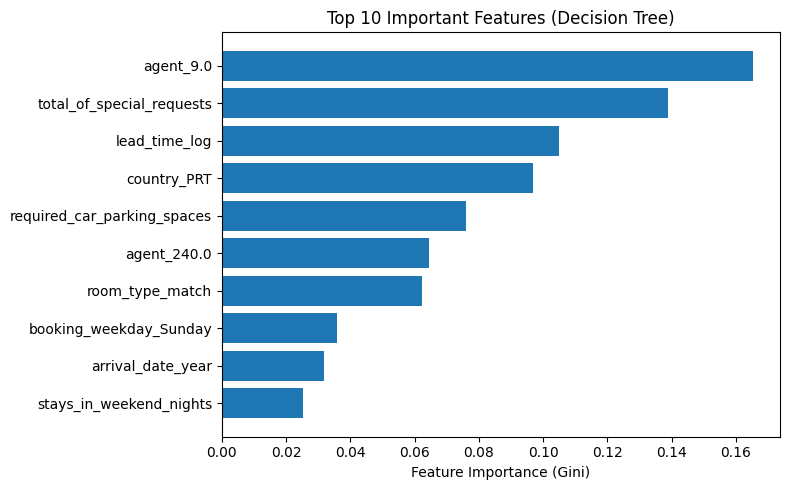

In [8]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train_val.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


In [9]:
feature_importances = pd.DataFrame({
    'feature': X_train_val.columns,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

                          feature  importance
521                     agent_9.0    0.165408
15      total_of_special_requests    0.138703
18                  lead_time_log    0.105035
154                   country_PRT    0.096942
14    required_car_parking_spaces    0.075864
..                            ...         ...
196  market_segment_Complementary    0.000000
195       market_segment_Aviation    0.000000
194                   country_ZWE    0.000000
193                   country_ZMB    0.000000
210       deposit_type_Refundable    0.000000

[547 rows x 2 columns]
